# KAN-ODE

## KODE网络训练

### 安装依赖

In [11]:
import sys
sys.path.append('/home/sdu123/WORK/KODE')

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import pandas as pd
from base_kan.ekan import EKAN  

### 定义网络
包含常规ODE和Neural ODE的SIR系统

In [13]:
class CustomSIRSystem(nn.Module):
    def __init__(self, neural_part, gamma, beta):
        super(CustomSIRSystem, self).__init__()
        self.neural_part = neural_part
        self.gamma = gamma
        self.beta = beta
        self.neural_outputs = []  # 用于记录neural_output

    def forward(self, t, y):
        S, I, R, A = y
        neural_output = self.neural_part(torch.tensor([S,I], dtype=torch.float32).unsqueeze(0)).squeeze()
        self.neural_outputs.append(neural_output.detach().numpy())  # 记录neural_output
        dR_dt = self.gamma * I
        dI_dt = abs(neural_output) - self.gamma * I
        dS_dt = - abs (neural_output)
        dA_dt = abs (neural_output)
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])

### 初始化模型参数

In [14]:
gamma = 0.07
beta = 2 * gamma  #根据实际情况，参数beta是参数gamma的具体倍数
neural_ode_func = EKAN(layers_hidden=[2, 128, 1])
model = CustomSIRSystem(neural_ode_func, gamma, beta)

### 初始化参数

In [15]:
intial = 0.  ##时间区间的初始值
last= 40.    ##时间区间的终值
step = 40   ##时间步长
y0 = torch.tensor([0.99, 0.01, 0.0, 0.0], requires_grad=True)  # 初始条件: S, I, R
t = torch.linspace(intial, last, step)  # 时间区间

### 生成真实数据

In [16]:
def get_data():
    gamma = 0.07
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0, 0.0])
    def sir(t, y):
        S, I, R, A= y
        dS_dt = -beta * S * I
        dI_dt = beta * S * I - gamma * I
        dR_dt = gamma * I
        dA_dt = beta * S * I
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, true_y = get_data()

### 定义损失函数
#### 使用仅与I相关的损失函数

In [17]:
def compute_loss(pred_y, true_y):
    return torch.mean((pred_y[:, 3] - true_y[:, 3]) ** 2)

### 定义准确率计算函数
#### 使用仅与I相关的准确率函数

In [18]:
def compute_accuracy(pred_y, true_y, threshold=0.01):
    diff = torch.abs(pred_y[:, 3] - true_y[:, 3])
    correct = (diff < threshold).float().mean()
    return correct.item()

### 定义训练模型
执行模型的训练

In [19]:
def train():
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for itr in range(2000):
        optimizer.zero_grad()
        pred_y = odeint(model, y0, t, rtol=1e-5, atol=1e-8)
        loss = compute_loss(pred_y, true_y)
        loss.backward()
        optimizer.step()

        if itr % 100 == 0:
            accuracy = compute_accuracy(pred_y, true_y)
            print(f'Iter {itr}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

    return t, true_y, pred_y, model.neural_outputs

### 进行训练

In [20]:
t, true_y, pred_y, neural_outputs = train()

Iter 0, Loss: 0.06340743601322174, Accuracy: 2.50%
Iter 100, Loss: 0.0011641859309747815, Accuracy: 15.00%
Iter 200, Loss: 0.0011156199034303427, Accuracy: 15.00%
Iter 300, Loss: 0.0010474781738594174, Accuracy: 15.00%
Iter 400, Loss: 0.0009646923281252384, Accuracy: 15.00%
Iter 500, Loss: 0.0008683651685714722, Accuracy: 15.00%
Iter 600, Loss: 0.0007593858754262328, Accuracy: 15.00%
Iter 700, Loss: 0.0006392333889380097, Accuracy: 17.50%
Iter 800, Loss: 0.0005108520272187889, Accuracy: 20.00%
Iter 900, Loss: 0.0003797694225795567, Accuracy: 25.00%
Iter 1000, Loss: 0.00025498640025034547, Accuracy: 30.00%
Iter 1100, Loss: 0.00014852453023195267, Accuracy: 42.50%
Iter 1200, Loss: 7.161368557717651e-05, Accuracy: 85.00%
Iter 1300, Loss: 2.7480386052047834e-05, Accuracy: 95.00%
Iter 1400, Loss: 8.28659631224582e-06, Accuracy: 100.00%
Iter 1500, Loss: 2.0306301848904695e-06, Accuracy: 100.00%
Iter 1600, Loss: 4.7072779807422194e-07, Accuracy: 100.00%
Iter 1700, Loss: 1.6463795304844098e-07

#### 定义差分机计算公式

In [21]:
def forword_CF(x):
    # 将输入转换为tensor
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
    # 检查输入长度是否至少为2
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
    # 初始化输出数列，复制第一个元素
    result = x.clone().detach()
    
    # 计算后一项减前一项
    result[1:] = x[1:] - x[:-1]
    
    return result

In [22]:
true_y[:,3] = forword_CF(true_y[:,3])
pred_y[:,3] = forword_CF(pred_y[:,3])

/tmp/ipykernel_757382/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


### 将最终数据保存至Excel

In [23]:
data = {
    'Time': t.numpy(),
    'True_S': true_y.numpy()[:, 0],
    'Predicted_S': pred_y.detach().numpy()[:, 0],
    'True_I': true_y.numpy()[:, 1],
    'Predicted_I': pred_y.detach().numpy()[:, 1],
    'True_R': true_y.numpy()[:, 2],
    'Predicted_R': pred_y.detach().numpy()[:, 2],
    'True_A': true_y.numpy()[:, 3],
    'Predicted_A': pred_y.detach().numpy()[:, 3],
}
df = pd.DataFrame(data)


### 保存成Excel文件

In [24]:
df.to_excel('/home/sdu123/WORK/KODE/YuCe/result/YC_A_Q.xlsx', index=False)

### 绘制结果并将图片结果保存

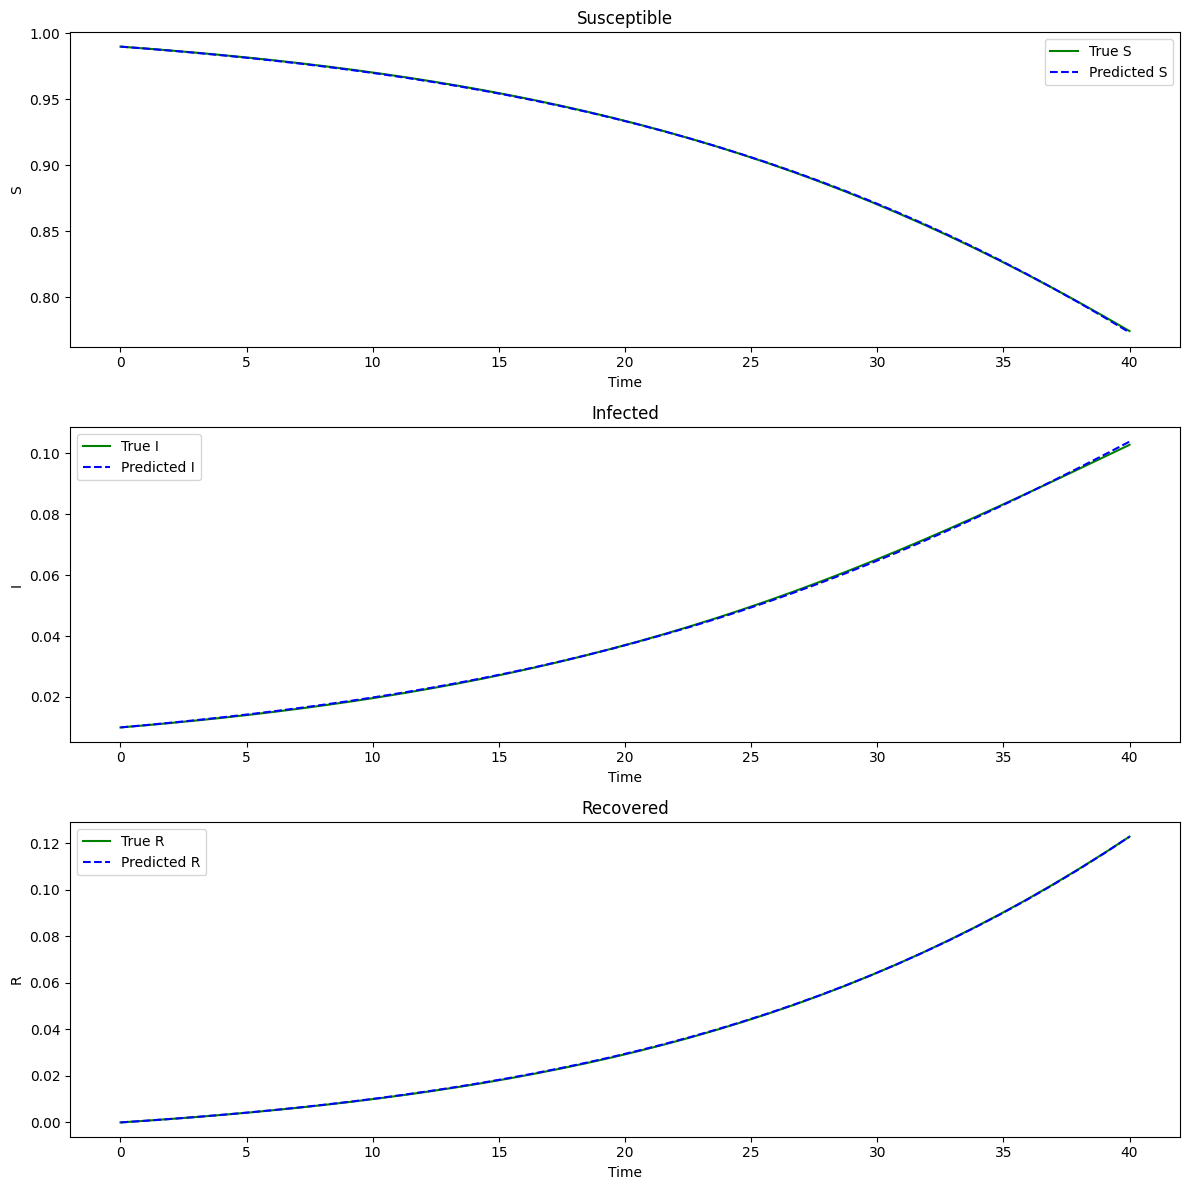

In [25]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t.numpy(), true_y.numpy()[:, 0], 'g-', label='True S')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 0], 'b--', label='Predicted S')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(t.numpy(), true_y.numpy()[:, 1], 'g-', label='True I')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 1], 'b--', label='Predicted I')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(t.numpy(), true_y.numpy()[:, 2], 'g-', label='True R')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 2], 'b--', label='Predicted R')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')

plt.tight_layout()
plt.savefig('/home/sdu123/WORK/KODE/YuCe/picture/YC_A_Q_SIR.png')
plt.show()


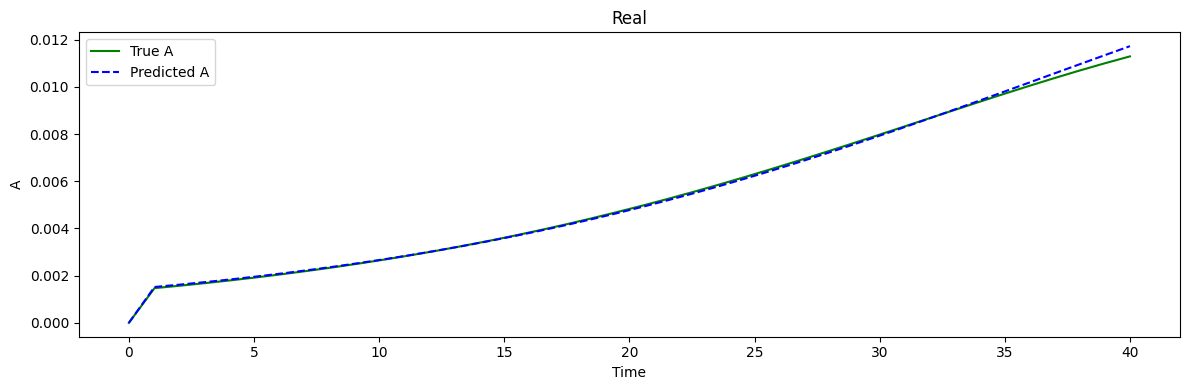

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(t.numpy(), true_y.numpy()[:, 3], 'g-', label='True A')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 3], 'b--', label='Predicted A')
plt.legend()
plt.xlabel('Time')
plt.ylabel('A')
plt.title('Real')

plt.tight_layout()
plt.savefig('/home/sdu123/WORK/KODE/YuCe/picture/YC_A_Q_true.png')
plt.show()

## 推理阶段

### 设置预测的时间

In [27]:
##将时间步长进行扩展
extend = 40
timeintial = intial
timeend = last + extend
timestep = step + extend
in_t = torch.linspace(timeintial, timeend, timestep)##预测接下来extend天的情况

### 机理部分的推理

In [28]:
def get_data():
    gamma = 0.07
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0, 0.0])
    def sir(t, y):
        S, I, R, A = y
        dS_dt = -beta * S * I
        dI_dt = beta * S * I  - gamma * I
        dR_dt = gamma * I
        dA_dt = beta * S * I
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])
    with torch.no_grad():
        in_true_y = odeint(sir, true_y0, in_t, rtol=1e-5, atol=1e-8)
    return in_t, in_true_y

in_t, in_true_y = get_data()

### 神经网络部分的推理

In [29]:
with torch.no_grad():
    in_pred_y = odeint(model, y0, in_t, rtol=1e-5, atol=1e-8)

#### 定义差分机计算公式

In [30]:
def forword_CF(x):
    # 将输入转换为tensor
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
    # 检查输入长度是否至少为2
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
    # 初始化输出数列，复制第一个元素
    result = x.clone().detach()
    
    # 计算后一项减前一项
    result[1:] = x[1:] - x[:-1]
    
    return result

In [31]:
in_true_y[:,3] = forword_CF(in_true_y[:,3])
in_pred_y[:,3] = forword_CF(in_pred_y[:,3])

/tmp/ipykernel_757382/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


### 将推理阶段的结果进行保存

In [32]:
in_data = {
    'Time': in_t.numpy(),
    'in_True_S': in_true_y.numpy()[:, 0],
    'in_Predicted_S': in_pred_y.detach().numpy()[:, 0],
    'in_True_I': in_true_y.numpy()[:, 1],
    'in_Predicted_I': in_pred_y.detach().numpy()[:, 1],
    'in_True_R': in_true_y.numpy()[:, 2],
    'in_Predicted_R': in_pred_y.detach().numpy()[:, 2],
    'in_True_A': in_true_y.numpy()[:, 3],
    'in_Predicted_A': in_pred_y.detach().numpy()[:, 3],
}
in_df = pd.DataFrame(in_data)
in_df.to_excel('/home/sdu123/WORK/KODE/YuCe/result/in_YC_A_Q.xlsx', index=False)

### 将推理阶段可视化

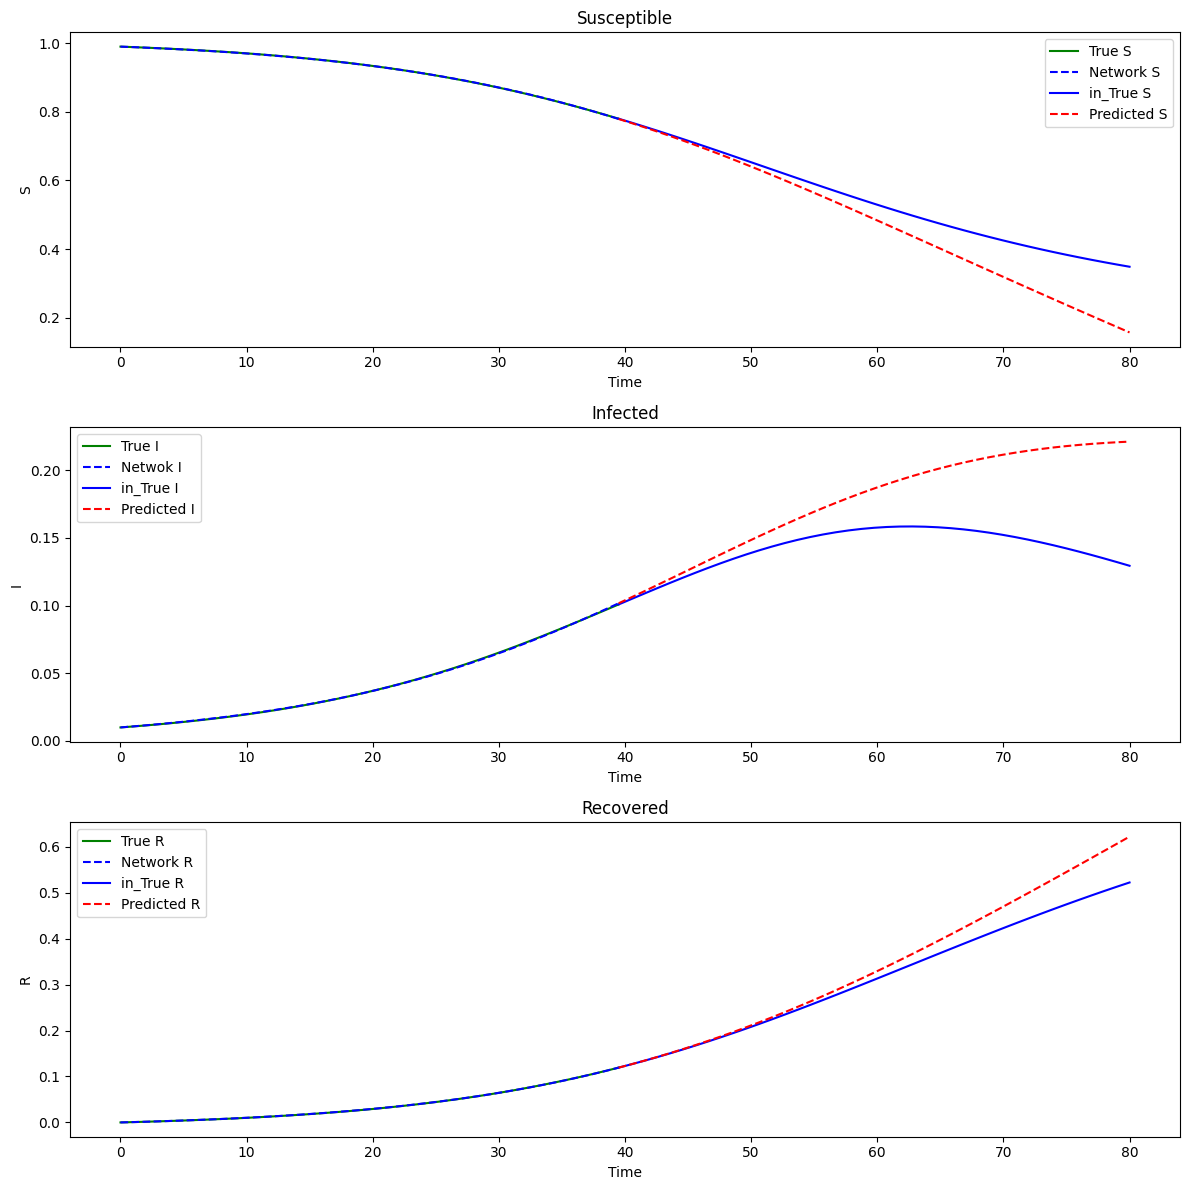

In [33]:
last = int(last)
timeend = int(timeend)
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 0], 'g-', label='True S')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 0], 'b--', label='Network S')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 0], 'b-', label='in_True S')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 0], 'r--', label='Predicted S')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 1], 'g-', label='True I')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 1], 'b--', label='Netwok I')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 1], 'b-', label='in_True I')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 1], 'r--', label='Predicted I')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 2], 'g-', label='True R')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 2], 'b--', label='Network R')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 2], 'b-', label='in_True R')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 2], 'r--', label='Predicted R')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')

plt.tight_layout()
plt.savefig('/home/sdu123/WORK/KODE/YuCe/picture/in_YC_A_Q_SIR.png')
plt.show()

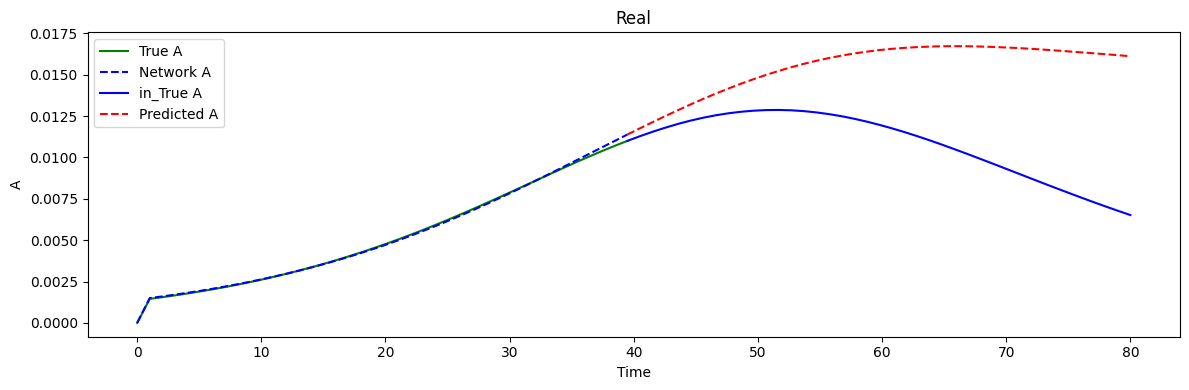

In [34]:
plt.figure(figsize=(12, 4))
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 3], 'g-', label='True A')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 3], 'b--', label='Network A')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 3], 'b-', label='in_True A')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 3], 'r--', label='Predicted A')
plt.legend()
plt.xlabel('Time')
plt.ylabel('A')
plt.title('Real')

plt.tight_layout()
plt.savefig('/home/sdu123/WORK/KODE/YuCe/picture/in_YC_A_Q_true.png')
plt.show()